# Improving DCA for Bitcoin Accumulation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hypertrial/stacking_sats_challenge/blob/main/tutorials/1.%20Intro.ipynb)

### 📘 **Intro Tutorial: Hypertrial Stacking Sats Challenge**

Welcome to the **Intro** tutorial for the [**Hypertrial Stacking Sats Challenge**](https://www.hypertrial.ai/trading-arena/challenge/bitcoin).

By the end of this notebook, you’ll understand:

1. ✅ The **advantages** of Bitcoin Dollar Cost Averaging (DCA)  
2. ⚠️ The **limitations** of Bitcoin DCA  
3. 🔁 The **motivation** for a more adaptive approach: **Dynamic DCA**

# Imports

If any package fails to import, install it inline using:
```bash
!pip install <package_name>

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
from coinmetrics.api_client import CoinMetricsClient
import logging

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

# Helpers & Global Variables

### ⚠️ **IMPORTANT REMINDER** ⚠️

Before proceeding, **make sure you've downloaded and saved** the file `dynamic_weight.csv` in your working directory.

📁 You can download it from the following link:  
👉 [Stacking-Sats GitHub Repository (tutorials folder)](https://github.com/hypertrial/Stacking-Sats/tree/main/tutorials)

In [ ]:
# 📁 Uploading your CSV file
# --------------------------
# If you're running this notebook in Google Colab:
# Uncomment the lines below to upload a local CSV file from your computer.
# After uploading, you can access the file by its filename in pd.read_csv().

# from google.colab import files
# uploaded = files.upload()

# If you're running this notebook locally (e.g. Jupyter Notebook or VS Code):
# Just make sure your CSV file is in the same folder as this notebook,
# or provide the full path when calling pd.read_csv().

In [8]:
# Global configuration variables
BACKTEST_START = '2013-01-01'
BACKTEST_END = '2024-12-31'
CYCLE_LENGTH = pd.DateOffset(years=4)  # 4-year cycle
BUDGET = 1  # Normalized budget for each cycle

# Read dynamic weights from CSV
dynamic_weights_df = pd.read_csv('dynamic_weights.csv', index_col=0, parse_dates=True)

In [9]:
# -----------------------------------------------------------------------------
# Helper Functions
# -----------------------------------------------------------------------------
def get_cycle_end(current_start):
    """Returns the end date of the cycle given the current start date using global BACKTEST_END and CYCLE_LENGTH."""
    global BACKTEST_END, CYCLE_LENGTH
    cycle_end = min(current_start + CYCLE_LENGTH - pd.Timedelta(days=1), pd.to_datetime(BACKTEST_END))
    return cycle_end

def get_cycle_label(current_start, current_end):
    """Generate a cycle label as 'YYYY–YYYY'."""
    return f"{current_start.year}–{current_end.year}"


def compute_min_max_spd(cycle_df):
    """Compute the min and max SPD (sats per dollar) for the cycle.
       min_spd: buying at cycle high (worst-case)
       max_spd: buying at cycle low (best-case)"""
    cycle_high = cycle_df['btc_close'].max()  # worst-case price (high)
    cycle_low = cycle_df['btc_close'].min()     # best-case price (low)
    min_spd = (1 / cycle_high) * 100_000_000
    max_spd = (1 / cycle_low) * 100_000_000
    return min_spd, max_spd

def compute_uniform_spd(cycle_df):
    """Compute the uniform DCA SPD using equal daily investments over the cycle."""
    global BUDGET
    dca_amount_per_day = BUDGET / len(cycle_df)
    btc_dca_accumulated = (dca_amount_per_day / cycle_df['btc_close']).sum()
    uniform_spd = btc_dca_accumulated * 100_000_000
    return uniform_spd

def compute_btc_uniform(cycle_df):
    global BUDGET
    daily_allocation = BUDGET / len(cycle_df)
    btc_uniform = (daily_allocation / cycle_df['btc_close']).sum()
    return btc_uniform

def compute_uniform_pct(uniform_spd, min_spd, max_spd):
    """Compute the normalized percentile for Uniform DCA SPD,
       where 0% corresponds to min_spd and 100% corresponds to max_spd."""
    return ((uniform_spd - min_spd) / (max_spd - min_spd)) * 100

def compute_dynamic_spd(cycle_df, dynamic_weights_df):
    """
    Compute the dynamic weighted SPD for the cycle.
    It extracts the dynamic weights for the same dates as in cycle_df, normalizes them so that
    they sum to 1, and uses them to weight the daily investment.
    """
    # Align dynamic weights to cycle dates
    weights = dynamic_weights_df.loc[cycle_df.index, '0']
    # Normalize the weights to sum to 1
    norm_weights = weights / weights.sum()
    # Daily DCA using dynamic allocation
    btc_dynamic_accumulated = ((norm_weights * BUDGET) / cycle_df['btc_close']).sum()
    dynamic_spd = btc_dynamic_accumulated * 100_000_000
    return dynamic_spd

# -----------------------------------------------------------------------------
# Plotting Helper
# -----------------------------------------------------------------------------
def plot_cycle_metrics():
    """Plot SPD values and Uniform DCA SPD Percentile over cycles."""
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Primary Y-axis: SPD values on a log scale
    ax1.set_yscale("log")
    ax1.plot(cycle_labels, max_spd_list, marker='o', linestyle='-', label="Max SPD (Cycle Low)", color='green')
    ax1.plot(cycle_labels, uniform_spd_list, marker='o', linestyle='-', label="Uniform DCA SPD", color='blue')
    ax1.plot(cycle_labels, min_spd_list, marker='o', linestyle='-', label="Min SPD (Cycle High)", color='red')
    ax1.set_ylabel("Sats per Dollar (SPD, Log Scale)")
    ax1.set_title("SPD and Uniform DCA SPD Percentile over 4-Year Cycles")
    ax1.legend(loc="upper left")
    ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax1.set_xticks(range(len(cycle_labels)))
    ax1.set_xticklabels(cycle_labels)
    
    # Secondary Y-axis: Uniform DCA SPD Percentile (0 to 100)
    ax2 = ax1.twinx()
    bar_width = 0.4
    ax2.bar(range(len(cycle_labels)), uniform_pct_list, width=bar_width, alpha=0.3,
            color='purple', label="Uniform DCA SPD %")
    ax2.set_ylabel("Uniform DCA SPD Percentile (%)")
    ax2.set_ylim(0, 100)
    ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
    ax2.legend(loc="upper right")
    
    plt.tight_layout()
    plt.show()


# %% [Plotting the Excess SPD and ROI Improvement]
def plot_excess_spd_and_roi():
    """
    Plot the excess SPD (Dynamic SPD % minus Uniform SPD %) on the left y-axis,
    and ROI improvement (%) on the right y-axis over the cycles.
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot excess SPD (line plot)
    ax1.plot(cycle_labels, excess_spd_list, marker='o', linestyle='-', label="Excess SPD (%)", color='blue')
    ax1.set_ylabel("Excess SPD (%)", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xlabel("Cycle")
    ax1.set_title("Excess SPD and ROI Improvement per Cycle")
    ax1.grid(True, linestyle='--', linewidth=0.5)

    # Secondary axis for ROI improvement (bar plot)
    ax2 = ax1.twinx()
    ax2.bar(cycle_labels, roi_improvement_list, alpha=0.3, label="ROI Improvement (%)", color='orange')
    ax2.set_ylabel("ROI Improvement (%)", color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

    # Legends and layout adjustments
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_cycle_metrics_with_dyanmic():
    """Plot SPD values and both Uniform & Dynamic DCA SPD Percentile over cycles."""
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Primary Y-axis: SPD values on a log scale
    ax1.set_yscale("log")
    ax1.plot(cycle_labels, max_spd_list, marker='o', linestyle='-', label="Max SPD (Cycle Low)", color='green')
    ax1.plot(cycle_labels, uniform_spd_list, marker='o', linestyle='-', label="Uniform DCA SPD", color='blue')
    ax1.plot(cycle_labels, dynamic_spd_list, marker='o', linestyle='-', label="Dynamic DCA SPD", color='orange')
    ax1.plot(cycle_labels, min_spd_list, marker='o', linestyle='-', label="Min SPD (Cycle High)", color='red')
    ax1.set_ylabel("Sats per Dollar (SPD, Log Scale)")
    ax1.set_title("SPD and DCA SPD Percentiles over 4-Year Cycles")
    ax1.legend(loc="upper left")
    ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax1.set_xticks(range(len(cycle_labels)))
    ax1.set_xticklabels(cycle_labels)
    
    # Secondary Y-axis: DCA SPD Percentiles (0 to 100)
    ax2 = ax1.twinx()
    bar_width = 0.35
    x = range(len(cycle_labels))
    ax2.bar([i - bar_width/2 for i in x], uniform_pct_list, width=bar_width, alpha=0.3,
            color='blue', label="Uniform DCA SPD %")
    ax2.bar([i + bar_width/2 for i in x], dynamic_pct_list, width=bar_width, alpha=0.3,
            color='orange', label="Dynamic DCA SPD %")
    ax2.set_ylabel("DCA SPD Percentile (%)")
    ax2.set_ylim(0, 100)
    ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
    ax2.legend(loc="upper right")
    
    plt.tight_layout()
    plt.show()

# Data

We’ll start by exploring and implementing our strategies using solely Bitcoin price data. Later, we plan to incorporate additional sources—such as on-chain data—to further refine our models.

In [12]:
# Configure logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Initialize Coin Metrics API client
client = CoinMetricsClient()

# Define the asset, metric, and time range
asset = 'btc'
metric = 'PriceUSD'
start_time = '2010-01-01'
end_time = datetime.today().strftime('%Y-%m-%d')  # Set end_time to today's date
frequency = '1d'

# Fetch the metric data for the specified asset and time range
logging.info("Fetching BTC ReferenceRate...")
btc_df = client.get_asset_metrics(
    assets=asset,
    metrics=[metric],
    frequency=frequency,
    start_time=start_time,
    end_time=end_time
).to_dataframe()

# Rename the 'ReferenceRate' column to 'Close'
btc_df = btc_df.rename(columns={metric: 'Close'})

# Set 'time' as the index and normalize to remove the time component but keep it as a DatetimeIndex
btc_df['time'] = pd.to_datetime(btc_df['time']).dt.normalize()

# Remove timezone information, if any
btc_df['time'] = btc_df['time'].dt.tz_localize(None)

# Set 'time' as the index
btc_df.set_index('time', inplace=True)

# Only keep close data
btc_df = btc_df[['Close']]

# Rename "Close" TO "BTC"
btc_df = btc_df.rename(columns={"Close": "btc_close"})

# Display
btc_df.info()
btc_df

2025-03-31 18:00:24 INFO     Fetching BTC ReferenceRate...
2025-03-31 18:00:26 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2025-03-31 18:00:34 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2025-03-31 18:00:42 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5371 entries, 2010-07-18 to 2025-03-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   btc_close  5371 non-null   Float64
dtypes: Float64(1)
memory usage: 89.2 KB


,btc_close
time,
2010-07-18,0.08584
2010-07-19,0.0808
2010-07-20,0.074736
2010-07-21,0.079193
2010-07-22,0.05847
...,...
2025-03-27,87211.324017
2025-03-28,84309.078355
2025-03-29,82497.179247


# Bitcoin DCA (The Standard, "Uniform" Approach)

Dollar Cost Averaging (DCA) is a popular approach where you invest a fixed amount at regular intervals. This strategy reduces timing risk and emotional biases by smoothing out volatility. But if Bitcoin DCA isn’t broken, why fix it? In this section, we’ll quantify the **opportunity cost** of Bitcoin DCA by comparing its Satoshis-per-dollar (spd) against the **best-case** (buying at the cycle low) and **worst-case** (buying at the cycle high) scenarios over a 4-year cycle. For generality, we standardize the budget to 1, since the results are effectively budget-invariant.

$$\text{spd} = \left(\frac{1}{\text{BTC/USD}}\right) \times 100{,}000{,}000$$

> **Note**: 100,000,000 Satoshis is equal to 1 BTC. 


Because spd values can vary significantly over time, we convert them to a percentile to better visualize how much value a uniform DCA strategy captures relative to the extreme cases:


$$\text{spd\_pct} = \left(\frac{\text{strategy\_spd} - \text{worst\_spd}}{\text{best\_spd} - \text{worst\_spd}}\right) \times 100$$

> **Note**: The normalized budget is chosen to preserve generality. Since spd is normalized, the absolute budget size does not affect these results unless you consider market slippage for very large buys (but this is beyond the scope of this challenge).

Below is a visualization comparing the **uniform DCA spd percentile** against the **best-case spd**, and **worst-case spd** over 4 year cycles ranging over the backtest period, `2013-01-01` to `2024-12-31`. Afterward, we’ll discuss the pros and cons of where a uniform Bitcoin DCA lands within that percentile range.

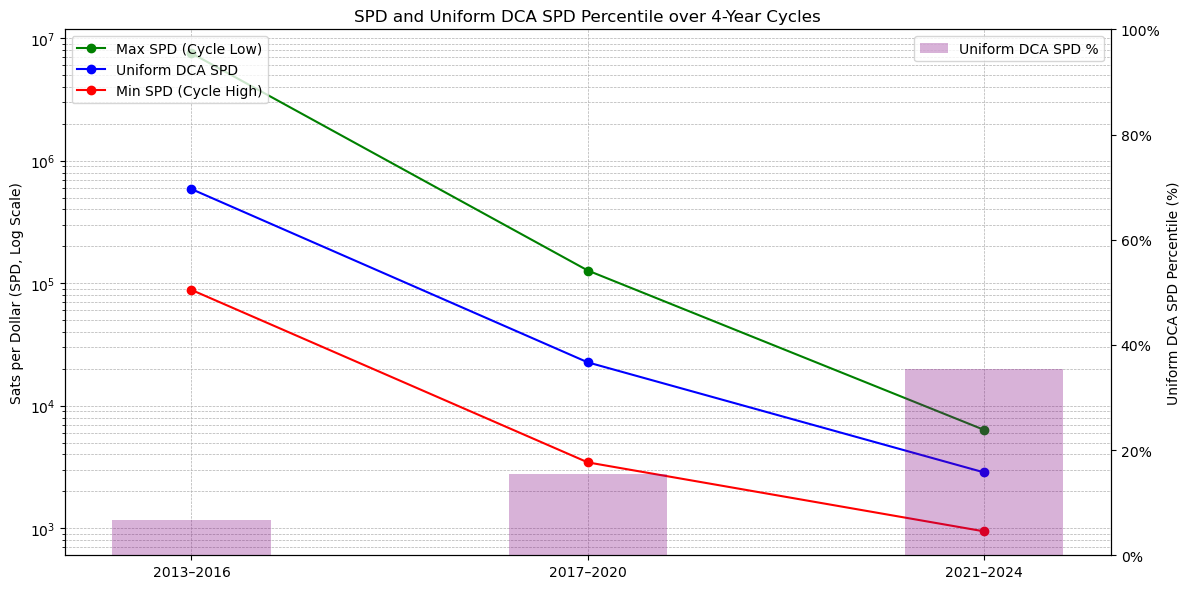

In [15]:
# -----------------------------------------------------------------------------
# Main Computation
# -----------------------------------------------------------------------------
# Convert BACKTEST_START to a datetime and initialize
current_start = pd.to_datetime(BACKTEST_START)

# Lists for storing cycle results
cycle_labels = []
min_spd_list = []
max_spd_list = []
uniform_spd_list = []
uniform_pct_list = []

while current_start <= pd.to_datetime(BACKTEST_END):
    current_end = get_cycle_end(current_start)
    cycle_df = btc_df.loc[current_start:current_end]
    
    if cycle_df.empty:
        break
    
    # Generate cycle label
    label = get_cycle_label(current_start, current_end)
    
    # Compute SPD values
    min_spd, max_spd = compute_min_max_spd(cycle_df)
    uniform_spd = compute_uniform_spd(cycle_df)
    uniform_pct = compute_uniform_pct(uniform_spd, min_spd, max_spd)
    
    # Append to lists
    cycle_labels.append(label)
    min_spd_list.append(min_spd)
    max_spd_list.append(max_spd)
    uniform_spd_list.append(uniform_spd)
    uniform_pct_list.append(uniform_pct)
    
    # Move to next cycle
    current_start += CYCLE_LENGTH


# -----------------------------------------------------------------------------
# Plot the computed metrics
# -----------------------------------------------------------------------------
plot_cycle_metrics()

## **Uniform DCA SPD Percentile Explanation**

- **🟢 Pro: Distance from 0% (Worst-Case)**  
  A higher percentile means you're further from the worst-case scenario—buying at the cycle high. Regular purchases help smooth volatility by avoiding concentrated buys at peak prices.

- **🔴 Con: Distance from 100% (Best-Case)**  
  A lower percentile means you're further from the best-case scenario—buying at the cycle low. Uniform DCA misses some upside that an adaptive strategy might capture by buying more during dips.

Despite this trade-off, **DCA remains valuable** for its simplicity, consistency, and reduced emotional interference.

---

### 💡 **Key Question**  
> **Can we preserve the core benefits of DCA—regular, systematic purchases and reduced emotional bias—while tailoring our purchase amounts to better exploit Bitcoin’s unique structural characteristics?**

---

In the next section, we **generalize uniform DCA into a dynamic accumulation strategy** that maintains the same budget and timeframe but uses **variable purchase amounts** guided by a model. This approach aims to retain DCA’s discipline while improving sats per dollar (SPD) efficiency.

--- 

# Toward Dynamic Accumulation Strategies (Dynamic DCA)

To illustrate the idea behind a dynamic DCA strategy, we’ll import pre-calculated weights from a future tutorial notebook. This approach allows us to focus on comparing the performance of these dynamic weights against uniform weights, rather than on the process of deriving them.

> **Note**: Weights are fundamental to our strategies. A uniform DCA strategy evenly allocates a normalized budget of 1 across all N days in a cycle—hence the name "uniform". In contrast, a dynamic DCA strategy assigns different weights to each of the N days, which is why it’s called "dynamic".

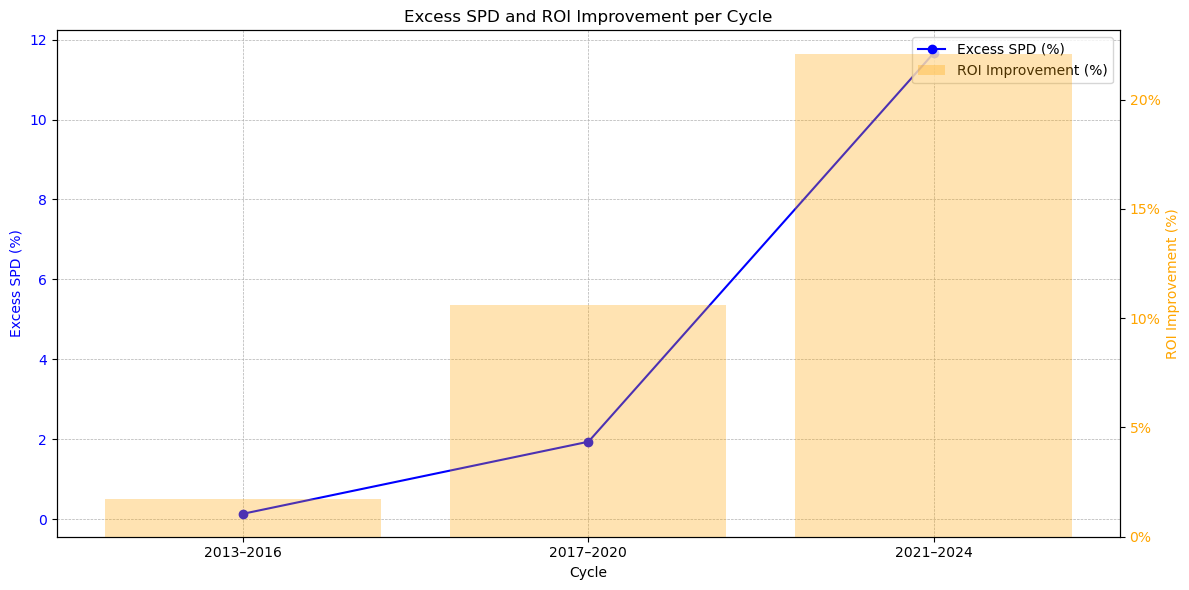

In [20]:
# %% [Main Computation]
# Initialize lists for storing cycle results
cycle_labels = []
min_spd_list = []
max_spd_list = []
uniform_spd_list = []
dynamic_spd_list = []
uniform_pct_list = []
dynamic_pct_list = []
excess_spd_list = []
roi_improvement_list = []

current_start = pd.to_datetime(BACKTEST_START)

while current_start <= pd.to_datetime(BACKTEST_END):
    current_end = get_cycle_end(current_start)
    cycle_df = btc_df.loc[current_start:current_end]
    if cycle_df.empty:
        break

    # Cycle label
    label = get_cycle_label(current_start, current_end)

    # Compute min and max SPD for the cycle
    min_spd, max_spd = compute_min_max_spd(cycle_df)

    # Uniform SPD and accumulated BTC
    uniform_spd = compute_uniform_spd(cycle_df)
    btc_uniform = compute_btc_uniform(cycle_df)
    uniform_pct = compute_uniform_pct(uniform_spd, min_spd, max_spd)

    # Dynamic SPD: Use dynamic weights for the same dates
    weights_slice = dynamic_weights_df.loc[cycle_df.index]
    # Use the first (and only) column since it is named "0"
    norm_weights = weights_slice.iloc[:, 0] / weights_slice.iloc[:, 0].sum()
    # Compute dynamic accumulated BTC with normalized daily allocation: norm_weight * BUDGET
    btc_dynamic = ((norm_weights * BUDGET) / cycle_df['btc_close']).sum()
    dynamic_spd = btc_dynamic * 100_000_000
    dynamic_pct = ((dynamic_spd - min_spd) / (max_spd - min_spd)) * 100

    # Excess SPD (percentile difference)
    excess_pct = dynamic_pct - uniform_pct

    # ROI improvement (percentage):
    # Final value for uniform = btc_uniform * final_price, and similarly for dynamic.
    # Since the budget is normalized to 1, the relative improvement simplifies to:
    # (btc_dynamic / btc_uniform - 1) * 100
    roi_improvement = (btc_dynamic / btc_uniform - 1) * 100

    # Append computed values to lists
    cycle_labels.append(label)
    min_spd_list.append(min_spd)
    max_spd_list.append(max_spd)
    uniform_spd_list.append(uniform_spd)
    dynamic_spd_list.append(dynamic_spd)
    uniform_pct_list.append(uniform_pct)
    dynamic_pct_list.append(dynamic_pct)
    excess_spd_list.append(excess_pct)
    roi_improvement_list.append(roi_improvement)

    # Move to the next cycle
    current_start += CYCLE_LENGTH

# %% [Plot the Metrics]
plot_excess_spd_and_roi()

The blue line (left y-axis) shows the extra sats per dollar percentage—also known as Excess SPD—achieved by using a dynamic DCA strategy over a uniform DCA approach. The orange bars (right y-axis) display the ROI improvement percentage if those sats were sold at the end of each cycle.

For now, please accept that even a relatively simple dynamic model (details to be revealed in later tutorials) produces these weights, resulting in a notable boost in both SPD and overall returns. This initial evidence suggests that basic dynamic adjustments can outperform uniform DCA while still maintaining its core benefits of steady accumulation and reduced emotional bias.

# Closing Remarks

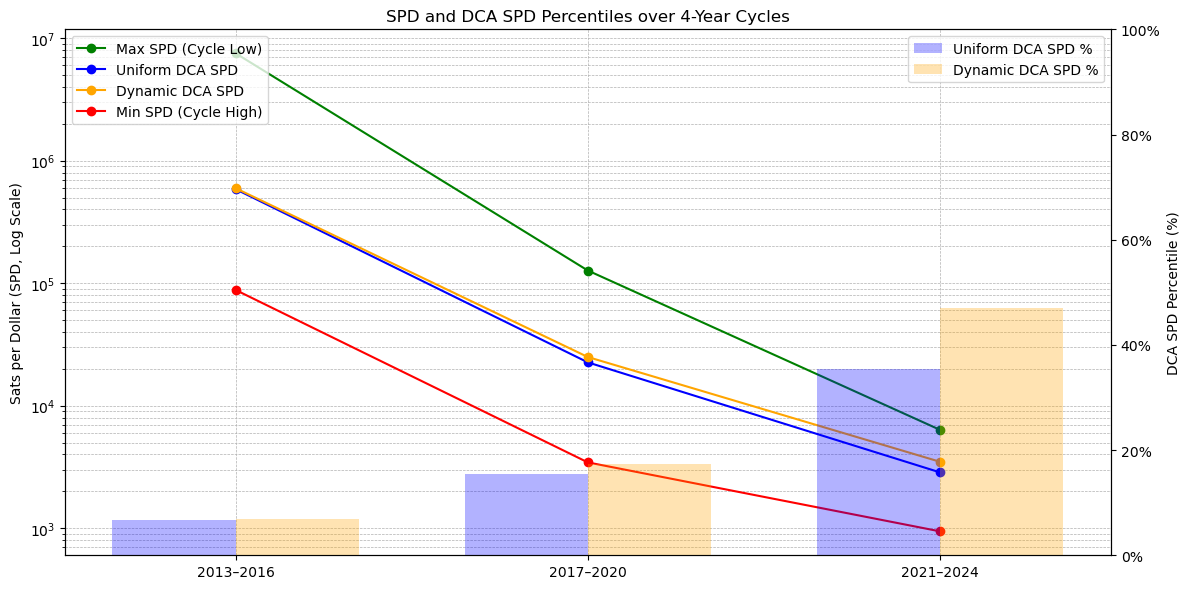

In [23]:
# Ensure the index is in datetime format
btc_df.index = pd.to_datetime(btc_df.index)
dynamic_weights_df.index = pd.to_datetime(dynamic_weights_df.index)  # Assuming similar structure

# -----------------------------------------------------------------------------
# Main Computation
# -----------------------------------------------------------------------------
# Convert BACKTEST_START to a datetime and initialize
current_start = pd.to_datetime(BACKTEST_START)

# Lists for storing cycle results
cycle_labels = []
min_spd_list = []
max_spd_list = []
uniform_spd_list = []
uniform_pct_list = []
dynamic_spd_list = []
dynamic_pct_list = []

while current_start <= pd.to_datetime(BACKTEST_END):
    current_end = get_cycle_end(current_start)
    cycle_df = btc_df.loc[current_start:current_end]
    
    if cycle_df.empty:
        break
    
    # Generate cycle label
    label = get_cycle_label(current_start, current_end)
    
    # Compute SPD values
    min_spd, max_spd = compute_min_max_spd(cycle_df)
    uniform_spd = compute_uniform_spd(cycle_df)
    dynamic_spd = compute_dynamic_spd(cycle_df, dynamic_weights_df)
    
    uniform_pct = compute_uniform_pct(uniform_spd, min_spd, max_spd)
    dynamic_pct = compute_uniform_pct(dynamic_spd, min_spd, max_spd)
    
    # Append to lists
    cycle_labels.append(label)
    min_spd_list.append(min_spd)
    max_spd_list.append(max_spd)
    uniform_spd_list.append(uniform_spd)
    uniform_pct_list.append(uniform_pct)
    dynamic_spd_list.append(dynamic_spd)
    dynamic_pct_list.append(dynamic_pct)
    
    # Move to next cycle
    current_start += CYCLE_LENGTH


# -----------------------------------------------------------------------------
# Plot the computed metrics
# -----------------------------------------------------------------------------
plot_cycle_metrics_with_dyanmic()

We believe you can develop dynamic DCA strategies that outperform the one shown here by leveraging Bitcoin's unique characteristics to achieve a higher SPD percentile. In [Tutorial 2](https://github.com/hypertrial/Stacking-Sats/blob/main/tutorials/2.%20Formal_Problem_Statment.ipynb), you'll learn what it means to implement **valid** dynamic accumulation strategies that maximize Bitcoin holdings while preserving the core benefits of uniform DCA. Then, in [Tutorial 3](https://github.com/hypertrial/Stacking-Sats/blob/main/tutorials/3.%20Submission_Template.ipynb), you'll see the code that generated the dynamic weights used in this notebook.